In [1]:
from dataclasses import dataclass
import torch
import os

### Helper Functions

In [2]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
def get_default_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_images(images, path, **kwargs):
    grid = make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to("cpu").numpy()
    im = Image.fromarray(ndarr)
    im.save(path)
    
def get(element: torch.Tensor, t: torch.Tensor):
    """
    Get value at index position "t" in "element" and
        reshape it to have the same dimension as a batch of images.
    """
    ele = element.gather(-1, t)
    return ele.reshape(-1, 1, 1, 1)

def setup_log_directory(config):
    '''Log and Model checkpoint directory Setup'''
    
    if os.path.isdir(config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = config.log_dir

    # Update the training config default directory 
    log_dir        = os.path.join(config.root_log_dir,        version_name)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(log_dir,        exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")
    print(f"Model Checkpoint at: {checkpoint_dir}")
    
    return log_dir, checkpoint_dir

def frames2vid(images, save_path):

    WIDTH = images[0].shape[1]
    HEIGHT = images[0].shape[0]

#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     fourcc = 0
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(save_path, fourcc, 25, (WIDTH, HEIGHT))

    # Appending the images to the video one by one
    for image in images:
        video.write(image)

    # Deallocating memories taken for window creation
    # cv2.destroyAllWindows()
    video.release()
    return 

def display_gif(gif_path):
    b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
    display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [3]:
@dataclass
class BaseConfig:
    DEVICE = get_default_device()
    #DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DATASET = "Flowers"  #  "MNIST", "Cifar-10", "Flowers"
 
    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "checkpoints")
 
    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"
 
 
@dataclass
class TrainingConfig:
    TIMESTEPS = 1000  # Define number of diffusion timesteps
    IMG_SHAPE = (1, 32, 32) if BaseConfig.DATASET == "MNIST" else (3, 32, 32)
    NUM_EPOCHS = 800
    BATCH_SIZE = 32
    LR = 2e-4
    NUM_WORKERS = 2

In [4]:
import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
 
def get_dataset(dataset_name='MNIST'):
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((32, 32), 
                                          interpolation=torchvision.transforms.InterpolationMode.BICUBIC, 
                                          antialias=True),
            torchvision.transforms.RandomHorizontalFlip(),
#             torchvision.transforms.Normalize(MEAN, STD),
            torchvision.transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
        ]
    )
     
    if dataset_name.upper() == "MNIST":
        dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-10":    
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-100":
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Flowers":
        dataset = datasets.ImageFolder(root="./flowers", transform=transforms)
 
    return dataset
 
def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

In [5]:
def get_dataloader(dataset_name='MNIST', 
                   batch_size=32, 
                   pin_memory=False, 
                   shuffle=True, 
                   num_workers=0, 
                   device="cpu"
                  ):
    dataset      = get_dataset(dataset_name=dataset_name)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            pin_memory=pin_memory, 
                            num_workers=num_workers, 
                            shuffle=shuffle
                           )
    # Used for moving batch of data to the user-specified machine: cpu or gpu
    device_dataloader = DeviceDataLoader(dataloader, device)
    return device_dataloader

In [6]:
loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=128,
    device="cpu",
)

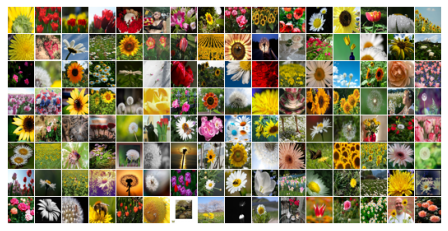

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4), facecolor='white')
 
for b_image, _ in loader:
    b_image = inverse_transform(b_image)
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [8]:
import gc
import os
import cv2
import math
import base64
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid

from torchmetrics import MeanMetric
from IPython.display import display, HTML, clear_output

### UNet Model

In [9]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)


class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)

        # group 2
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None]

        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)

        return h


class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)


class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x, *args):
        return self.upsample(x)


class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=128,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=4,
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)

                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t):

        time_emb = self.time_embeddings(t)

        h = self.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h

### Diffusion Class

In [16]:
class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 64, 64),
        device="cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device
        self.initialize()
 
    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta
         
        self_sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)
          
    def get_betas(self):
        """linear schedule, proposed in original ddpm paper"""
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )

### Forward Diffusion Process

In [11]:
def forward_diffusion(sd: SimpleDiffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    eps = torch.randn_like(x0)  # Noise
    mean    = get(sd.sqrt_alpha_cumulative, t=timesteps) * x0  # Image scaled
    std_dev = get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps) # Noise scaled
    sample  = mean + std_dev * eps # scaled inputs * scaled noise
 
    return sample, eps  # return ... , gt noise --> model predicts this

In [17]:
sd = SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device="cpu")
 
loader = iter(  # converting dataloader into an iterator for now.
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device="cpu",
    )
)

In [19]:
x0s, _ = next(loader)

noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = forward_diffusion(sd, x0s, timestep)
    xts = inverse_transform(xts) / 255.0
    xts = make_grid(xts, nrow=1, padding=1)

    noisy_images.append(xts)

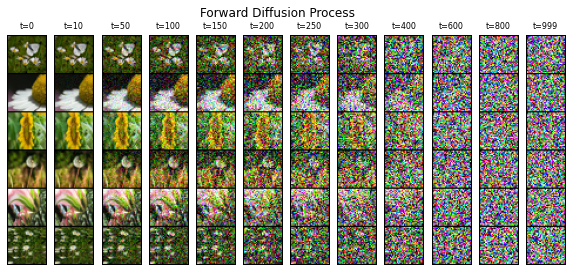

In [20]:
# Plot and see samples at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor='white')
 
for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)
 
plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

In [36]:
# Algorithm 1: Training

def train_one_epoch(model, sd, loader, optimizer, scaler, loss_fn, epoch=800, 
                   base_config=BaseConfig(), training_config=TrainingConfig()):
    
    loss_record = MeanMetric()
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{training_config.NUM_EPOCHS}")
         
        for x0s, _ in loader:
            tq.update(1)
            
            ts = torch.randint(low=1, high=training_config.TIMESTEPS, size=(x0s.shape[0],), device=base_config.DEVICE)
            xts, gt_noise = forward_diffusion(sd, x0s, ts)

            with amp.autocast():
                pred_noise = model(xts, ts)
                loss = loss_fn(gt_noise, pred_noise)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    
    return mean_loss 

In [37]:
# Algorithm 2: Sampling
     
@torch.no_grad()
def reverse_diffusion(model, sd, timesteps=1000, img_shape=(3, 64, 64), 
                      num_images=5, nrow=8, device="cpu", **kwargs):
 
    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()
 
    if kwargs.get("generate_video", False):
        outs = []
 
    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):
 
        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)
 
        predicted_noise = model(x, ts)
 
        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 
 
        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )
 
        if kwargs.get("generate_video", False):
            x_inv = inverse_transform(x).type(torch.uint8)
            grid = make_grid(x_inv, nrow=nrow, pad_value=255.0).to("cpu")
            ndarr = torch.permute(grid, (1, 2, 0)).numpy()[:, :, ::-1]
            outs.append(ndarr)
 
    if kwargs.get("generate_video", False): # Generate and save video of the entire reverse process. 
        frames2vid(outs, kwargs['save_path'])
        display(Image.fromarray(outs[-1][:, :, ::-1])) # Display the image at the final timestep of the reverse process.
        return None
 
    else: # Display and save the image at the final timestep of the reverse process. 
        x = inverse_transform(x).type(torch.uint8)
        grid = make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
        pil_image = TF.functional.to_pil_image(grid)
        pil_image.save(kwargs['save_path'], format=save_path[-3:].upper())
        display(pil_image)
        return None

In [38]:
@dataclass
class ModelConfig:
    BASE_CH = 64  # 64, 128, 256, 256
    BASE_CH_MULT = (1, 2, 4, 4) # 32, 16, 8, 8 
    APPLY_ATTENTION = (False, True, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 4 # 128
    
model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
model.to(BaseConfig.DEVICE)
 
optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR) # Original → Adam
 
dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pin_memory    = True,
    num_workers   = TrainingConfig.NUM_WORKERS,
)
 
loss_fn = nn.MSELoss()
 
sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)
 
scaler = amp.GradScaler() # For mixed-precision training.

In [39]:
total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())
generate_video = False
ext = ".mp4" if generate_video else ".png"

Logging at: Logs_Checkpoints/Inference/version_4
Model Checkpoint at: Logs_Checkpoints/checkpoints/version_4


Train :: Epoch: 1/800: 100%|█| 135/135 [00:08<00:00, 15.38it/s, Epoch Loss: 0.18
Train :: Epoch: 2/800: 100%|█| 135/135 [00:07<00:00, 18.21it/s, Epoch Loss: 0.08
Train :: Epoch: 3/800: 100%|█| 135/135 [00:07<00:00, 18.55it/s, Epoch Loss: 0.07
Train :: Epoch: 4/800: 100%|█| 135/135 [00:07<00:00, 18.22it/s, Epoch Loss: 0.06
Train :: Epoch: 5/800: 100%|█| 135/135 [00:07<00:00, 18.38it/s, Epoch Loss: 0.06
Train :: Epoch: 6/800: 100%|█| 135/135 [00:07<00:00, 18.96it/s, Epoch Loss: 0.05
Train :: Epoch: 7/800: 100%|█| 135/135 [00:07<00:00, 18.84it/s, Epoch Loss: 0.05
Train :: Epoch: 8/800: 100%|█| 135/135 [00:07<00:00, 18.79it/s, Epoch Loss: 0.06
Train :: Epoch: 9/800: 100%|█| 135/135 [00:07<00:00, 18.59it/s, Epoch Loss: 0.05
Train :: Epoch: 10/800: 100%|█| 135/135 [00:07<00:00, 18.59it/s, Epoch Loss: 0.0
Train :: Epoch: 11/800: 100%|█| 135/135 [00:07<00:00, 18.99it/s, Epoch Loss: 0.0
Train :: Epoch: 12/800: 100%|█| 135/135 [00:07<00:00, 19.04it/s, Epoch Loss: 0.0
Train :: Epoch: 13/800: 100%

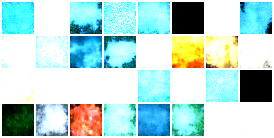

Train :: Epoch: 21/800: 100%|█| 135/135 [00:07<00:00, 17.53it/s, Epoch Loss: 0.0
Train :: Epoch: 22/800: 100%|█| 135/135 [00:07<00:00, 19.13it/s, Epoch Loss: 0.0
Train :: Epoch: 23/800: 100%|█| 135/135 [00:07<00:00, 18.99it/s, Epoch Loss: 0.0
Train :: Epoch: 24/800: 100%|█| 135/135 [00:07<00:00, 18.70it/s, Epoch Loss: 0.0
Train :: Epoch: 25/800: 100%|█| 135/135 [00:07<00:00, 18.35it/s, Epoch Loss: 0.0
Train :: Epoch: 26/800: 100%|█| 135/135 [00:07<00:00, 18.89it/s, Epoch Loss: 0.0
Train :: Epoch: 27/800: 100%|█| 135/135 [00:07<00:00, 17.74it/s, Epoch Loss: 0.0
Train :: Epoch: 28/800: 100%|█| 135/135 [00:07<00:00, 18.38it/s, Epoch Loss: 0.0
Train :: Epoch: 29/800: 100%|█| 135/135 [00:07<00:00, 18.23it/s, Epoch Loss: 0.0
Train :: Epoch: 30/800: 100%|█| 135/135 [00:07<00:00, 17.94it/s, Epoch Loss: 0.0
Train :: Epoch: 31/800: 100%|█| 135/135 [00:07<00:00, 18.75it/s, Epoch Loss: 0.0
Train :: Epoch: 32/800: 100%|█| 135/135 [00:07<00:00, 18.59it/s, Epoch Loss: 0.0
Train :: Epoch: 33/800: 100%

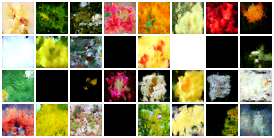

Train :: Epoch: 41/800: 100%|█| 135/135 [00:07<00:00, 18.18it/s, Epoch Loss: 0.0
Train :: Epoch: 42/800: 100%|█| 135/135 [00:07<00:00, 18.97it/s, Epoch Loss: 0.0
Train :: Epoch: 43/800: 100%|█| 135/135 [00:07<00:00, 18.91it/s, Epoch Loss: 0.0
Train :: Epoch: 44/800: 100%|█| 135/135 [00:07<00:00, 18.43it/s, Epoch Loss: 0.0
Train :: Epoch: 45/800: 100%|█| 135/135 [00:07<00:00, 17.47it/s, Epoch Loss: 0.0
Train :: Epoch: 46/800: 100%|█| 135/135 [00:07<00:00, 18.77it/s, Epoch Loss: 0.0
Train :: Epoch: 47/800: 100%|█| 135/135 [00:07<00:00, 18.84it/s, Epoch Loss: 0.0
Train :: Epoch: 48/800: 100%|█| 135/135 [00:07<00:00, 18.62it/s, Epoch Loss: 0.0
Train :: Epoch: 49/800: 100%|█| 135/135 [00:07<00:00, 17.83it/s, Epoch Loss: 0.0
Train :: Epoch: 50/800: 100%|█| 135/135 [00:07<00:00, 18.88it/s, Epoch Loss: 0.0
Train :: Epoch: 51/800: 100%|█| 135/135 [00:07<00:00, 18.96it/s, Epoch Loss: 0.0
Train :: Epoch: 52/800: 100%|█| 135/135 [00:07<00:00, 18.41it/s, Epoch Loss: 0.0
Train :: Epoch: 53/800: 100%

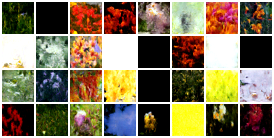

Train :: Epoch: 61/800: 100%|█| 135/135 [00:07<00:00, 17.74it/s, Epoch Loss: 0.0
Train :: Epoch: 62/800: 100%|█| 135/135 [00:07<00:00, 18.86it/s, Epoch Loss: 0.0
Train :: Epoch: 63/800: 100%|█| 135/135 [00:07<00:00, 18.63it/s, Epoch Loss: 0.0
Train :: Epoch: 64/800: 100%|█| 135/135 [00:07<00:00, 18.23it/s, Epoch Loss: 0.0
Train :: Epoch: 65/800: 100%|█| 135/135 [00:07<00:00, 18.93it/s, Epoch Loss: 0.0
Train :: Epoch: 66/800: 100%|█| 135/135 [00:07<00:00, 18.52it/s, Epoch Loss: 0.0
Train :: Epoch: 67/800: 100%|█| 135/135 [00:07<00:00, 17.74it/s, Epoch Loss: 0.0
Train :: Epoch: 68/800: 100%|█| 135/135 [00:07<00:00, 17.47it/s, Epoch Loss: 0.0
Train :: Epoch: 69/800: 100%|█| 135/135 [00:07<00:00, 17.51it/s, Epoch Loss: 0.0
Train :: Epoch: 70/800: 100%|█| 135/135 [00:07<00:00, 17.65it/s, Epoch Loss: 0.0
Train :: Epoch: 71/800: 100%|█| 135/135 [00:07<00:00, 17.47it/s, Epoch Loss: 0.0
Train :: Epoch: 72/800: 100%|█| 135/135 [00:07<00:00, 17.48it/s, Epoch Loss: 0.0
Train :: Epoch: 73/800: 100%

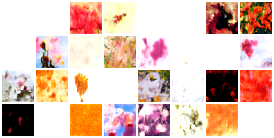

Train :: Epoch: 81/800: 100%|█| 135/135 [00:07<00:00, 17.05it/s, Epoch Loss: 0.0
Train :: Epoch: 82/800: 100%|█| 135/135 [00:07<00:00, 18.79it/s, Epoch Loss: 0.0
Train :: Epoch: 83/800: 100%|█| 135/135 [00:07<00:00, 18.69it/s, Epoch Loss: 0.0
Train :: Epoch: 84/800: 100%|█| 135/135 [00:07<00:00, 18.07it/s, Epoch Loss: 0.0
Train :: Epoch: 85/800: 100%|█| 135/135 [00:07<00:00, 17.23it/s, Epoch Loss: 0.0
Train :: Epoch: 86/800: 100%|█| 135/135 [00:07<00:00, 17.31it/s, Epoch Loss: 0.0
Train :: Epoch: 87/800: 100%|█| 135/135 [00:07<00:00, 17.62it/s, Epoch Loss: 0.0
Train :: Epoch: 88/800: 100%|█| 135/135 [00:07<00:00, 17.64it/s, Epoch Loss: 0.0
Train :: Epoch: 89/800: 100%|█| 135/135 [00:07<00:00, 17.64it/s, Epoch Loss: 0.0
Train :: Epoch: 90/800: 100%|█| 135/135 [00:07<00:00, 18.30it/s, Epoch Loss: 0.0
Train :: Epoch: 91/800: 100%|█| 135/135 [00:07<00:00, 18.08it/s, Epoch Loss: 0.0
Train :: Epoch: 92/800: 100%|█| 135/135 [00:07<00:00, 18.19it/s, Epoch Loss: 0.0
Train :: Epoch: 93/800: 100%

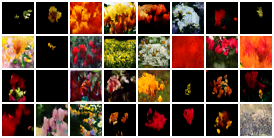

Train :: Epoch: 101/800: 100%|█| 135/135 [00:07<00:00, 17.54it/s, Epoch Loss: 0.
Train :: Epoch: 102/800: 100%|█| 135/135 [00:07<00:00, 17.95it/s, Epoch Loss: 0.
Train :: Epoch: 103/800: 100%|█| 135/135 [00:07<00:00, 18.05it/s, Epoch Loss: 0.
Train :: Epoch: 104/800: 100%|█| 135/135 [00:07<00:00, 17.77it/s, Epoch Loss: 0.
Train :: Epoch: 105/800: 100%|█| 135/135 [00:07<00:00, 17.77it/s, Epoch Loss: 0.
Train :: Epoch: 106/800: 100%|█| 135/135 [00:07<00:00, 17.67it/s, Epoch Loss: 0.
Train :: Epoch: 107/800: 100%|█| 135/135 [00:07<00:00, 18.44it/s, Epoch Loss: 0.
Train :: Epoch: 108/800: 100%|█| 135/135 [00:07<00:00, 18.44it/s, Epoch Loss: 0.
Train :: Epoch: 109/800: 100%|█| 135/135 [00:07<00:00, 18.39it/s, Epoch Loss: 0.
Train :: Epoch: 110/800: 100%|█| 135/135 [00:07<00:00, 18.13it/s, Epoch Loss: 0.
Train :: Epoch: 111/800: 100%|█| 135/135 [00:07<00:00, 18.22it/s, Epoch Loss: 0.
Train :: Epoch: 112/800: 100%|█| 135/135 [00:07<00:00, 18.40it/s, Epoch Loss: 0.
Train :: Epoch: 113/800: 100

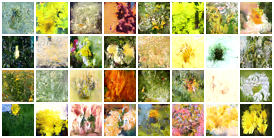

Train :: Epoch: 121/800: 100%|█| 135/135 [00:07<00:00, 18.22it/s, Epoch Loss: 0.
Train :: Epoch: 122/800: 100%|█| 135/135 [00:07<00:00, 18.36it/s, Epoch Loss: 0.
Train :: Epoch: 123/800: 100%|█| 135/135 [00:07<00:00, 18.07it/s, Epoch Loss: 0.
Train :: Epoch: 124/800: 100%|█| 135/135 [00:07<00:00, 17.07it/s, Epoch Loss: 0.
Train :: Epoch: 125/800: 100%|█| 135/135 [00:07<00:00, 17.48it/s, Epoch Loss: 0.
Train :: Epoch: 126/800: 100%|█| 135/135 [00:07<00:00, 17.54it/s, Epoch Loss: 0.
Train :: Epoch: 127/800: 100%|█| 135/135 [00:07<00:00, 17.47it/s, Epoch Loss: 0.
Train :: Epoch: 128/800: 100%|█| 135/135 [00:07<00:00, 17.38it/s, Epoch Loss: 0.
Train :: Epoch: 129/800: 100%|█| 135/135 [00:07<00:00, 18.94it/s, Epoch Loss: 0.
Train :: Epoch: 130/800: 100%|█| 135/135 [00:07<00:00, 19.04it/s, Epoch Loss: 0.
Train :: Epoch: 131/800: 100%|█| 135/135 [00:07<00:00, 18.32it/s, Epoch Loss: 0.
Train :: Epoch: 132/800: 100%|█| 135/135 [00:07<00:00, 17.35it/s, Epoch Loss: 0.
Train :: Epoch: 133/800: 100

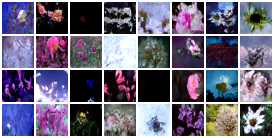

Train :: Epoch: 141/800: 100%|█| 135/135 [00:07<00:00, 17.37it/s, Epoch Loss: 0.
Train :: Epoch: 142/800: 100%|█| 135/135 [00:07<00:00, 17.51it/s, Epoch Loss: 0.
Train :: Epoch: 143/800: 100%|█| 135/135 [00:07<00:00, 17.77it/s, Epoch Loss: 0.
Train :: Epoch: 144/800: 100%|█| 135/135 [00:07<00:00, 17.81it/s, Epoch Loss: 0.
Train :: Epoch: 145/800: 100%|█| 135/135 [00:07<00:00, 17.41it/s, Epoch Loss: 0.
Train :: Epoch: 146/800: 100%|█| 135/135 [00:07<00:00, 18.73it/s, Epoch Loss: 0.
Train :: Epoch: 147/800: 100%|█| 135/135 [00:07<00:00, 18.93it/s, Epoch Loss: 0.
Train :: Epoch: 148/800: 100%|█| 135/135 [00:07<00:00, 18.48it/s, Epoch Loss: 0.
Train :: Epoch: 149/800: 100%|█| 135/135 [00:07<00:00, 17.71it/s, Epoch Loss: 0.
Train :: Epoch: 150/800: 100%|█| 135/135 [00:07<00:00, 17.80it/s, Epoch Loss: 0.
Train :: Epoch: 151/800: 100%|█| 135/135 [00:07<00:00, 17.63it/s, Epoch Loss: 0.
Train :: Epoch: 152/800: 100%|█| 135/135 [00:07<00:00, 17.82it/s, Epoch Loss: 0.
Train :: Epoch: 153/800: 100

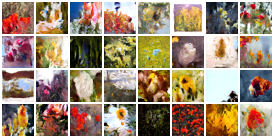

Train :: Epoch: 161/800: 100%|█| 135/135 [00:07<00:00, 17.36it/s, Epoch Loss: 0.
Train :: Epoch: 162/800: 100%|█| 135/135 [00:07<00:00, 17.83it/s, Epoch Loss: 0.
Train :: Epoch: 163/800: 100%|█| 135/135 [00:07<00:00, 18.05it/s, Epoch Loss: 0.
Train :: Epoch: 164/800: 100%|█| 135/135 [00:07<00:00, 18.33it/s, Epoch Loss: 0.
Train :: Epoch: 165/800: 100%|█| 135/135 [00:07<00:00, 17.76it/s, Epoch Loss: 0.
Train :: Epoch: 166/800: 100%|█| 135/135 [00:07<00:00, 18.00it/s, Epoch Loss: 0.
Train :: Epoch: 167/800: 100%|█| 135/135 [00:07<00:00, 17.88it/s, Epoch Loss: 0.
Train :: Epoch: 168/800: 100%|█| 135/135 [00:07<00:00, 17.27it/s, Epoch Loss: 0.
Train :: Epoch: 169/800: 100%|█| 135/135 [00:07<00:00, 17.43it/s, Epoch Loss: 0.
Train :: Epoch: 170/800: 100%|█| 135/135 [00:07<00:00, 17.79it/s, Epoch Loss: 0.
Train :: Epoch: 171/800: 100%|█| 135/135 [00:07<00:00, 18.00it/s, Epoch Loss: 0.
Train :: Epoch: 172/800: 100%|█| 135/135 [00:07<00:00, 17.69it/s, Epoch Loss: 0.
Train :: Epoch: 173/800: 100

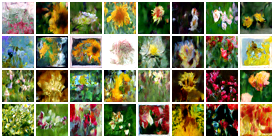

Train :: Epoch: 181/800: 100%|█| 135/135 [00:07<00:00, 17.68it/s, Epoch Loss: 0.
Train :: Epoch: 182/800: 100%|█| 135/135 [00:07<00:00, 19.15it/s, Epoch Loss: 0.
Train :: Epoch: 183/800: 100%|█| 135/135 [00:07<00:00, 18.92it/s, Epoch Loss: 0.
Train :: Epoch: 184/800: 100%|█| 135/135 [00:07<00:00, 18.02it/s, Epoch Loss: 0.
Train :: Epoch: 185/800: 100%|█| 135/135 [00:07<00:00, 17.76it/s, Epoch Loss: 0.
Train :: Epoch: 186/800: 100%|█| 135/135 [00:07<00:00, 17.79it/s, Epoch Loss: 0.
Train :: Epoch: 187/800: 100%|█| 135/135 [00:07<00:00, 17.43it/s, Epoch Loss: 0.
Train :: Epoch: 188/800: 100%|█| 135/135 [00:07<00:00, 17.47it/s, Epoch Loss: 0.
Train :: Epoch: 189/800: 100%|█| 135/135 [00:07<00:00, 17.62it/s, Epoch Loss: 0.
Train :: Epoch: 190/800: 100%|█| 135/135 [00:07<00:00, 18.94it/s, Epoch Loss: 0.
Train :: Epoch: 191/800: 100%|█| 135/135 [00:07<00:00, 18.78it/s, Epoch Loss: 0.
Train :: Epoch: 192/800: 100%|█| 135/135 [00:07<00:00, 18.61it/s, Epoch Loss: 0.
Train :: Epoch: 193/800: 100

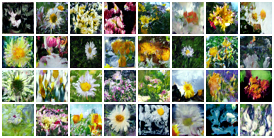

Train :: Epoch: 201/800: 100%|█| 135/135 [00:07<00:00, 17.67it/s, Epoch Loss: 0.
Train :: Epoch: 202/800: 100%|█| 135/135 [00:07<00:00, 17.87it/s, Epoch Loss: 0.
Train :: Epoch: 203/800: 100%|█| 135/135 [00:07<00:00, 17.82it/s, Epoch Loss: 0.
Train :: Epoch: 204/800: 100%|█| 135/135 [00:07<00:00, 17.51it/s, Epoch Loss: 0.
Train :: Epoch: 205/800: 100%|█| 135/135 [00:07<00:00, 17.60it/s, Epoch Loss: 0.
Train :: Epoch: 206/800: 100%|█| 135/135 [00:07<00:00, 17.65it/s, Epoch Loss: 0.
Train :: Epoch: 207/800: 100%|█| 135/135 [00:07<00:00, 17.31it/s, Epoch Loss: 0.
Train :: Epoch: 208/800: 100%|█| 135/135 [00:07<00:00, 17.67it/s, Epoch Loss: 0.
Train :: Epoch: 209/800: 100%|█| 135/135 [00:07<00:00, 17.47it/s, Epoch Loss: 0.
Train :: Epoch: 210/800: 100%|█| 135/135 [00:07<00:00, 18.00it/s, Epoch Loss: 0.
Train :: Epoch: 211/800: 100%|█| 135/135 [00:07<00:00, 18.50it/s, Epoch Loss: 0.
Train :: Epoch: 212/800: 100%|█| 135/135 [00:07<00:00, 18.38it/s, Epoch Loss: 0.
Train :: Epoch: 213/800: 100

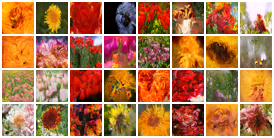

Train :: Epoch: 221/800: 100%|█| 135/135 [00:07<00:00, 17.92it/s, Epoch Loss: 0.
Train :: Epoch: 222/800: 100%|█| 135/135 [00:07<00:00, 18.07it/s, Epoch Loss: 0.
Train :: Epoch: 223/800: 100%|█| 135/135 [00:07<00:00, 18.03it/s, Epoch Loss: 0.
Train :: Epoch: 224/800: 100%|█| 135/135 [00:07<00:00, 17.73it/s, Epoch Loss: 0.
Train :: Epoch: 225/800: 100%|█| 135/135 [00:07<00:00, 17.42it/s, Epoch Loss: 0.
Train :: Epoch: 226/800: 100%|█| 135/135 [00:07<00:00, 17.52it/s, Epoch Loss: 0.
Train :: Epoch: 227/800: 100%|█| 135/135 [00:07<00:00, 17.68it/s, Epoch Loss: 0.
Train :: Epoch: 228/800: 100%|█| 135/135 [00:07<00:00, 17.85it/s, Epoch Loss: 0.
Train :: Epoch: 229/800: 100%|█| 135/135 [00:07<00:00, 17.75it/s, Epoch Loss: 0.
Train :: Epoch: 230/800: 100%|█| 135/135 [00:07<00:00, 17.98it/s, Epoch Loss: 0.
Train :: Epoch: 231/800: 100%|█| 135/135 [00:07<00:00, 17.77it/s, Epoch Loss: 0.
Train :: Epoch: 232/800: 100%|█| 135/135 [00:07<00:00, 17.44it/s, Epoch Loss: 0.
Train :: Epoch: 233/800: 100

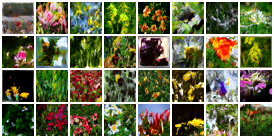

Train :: Epoch: 241/800: 100%|█| 135/135 [00:08<00:00, 16.79it/s, Epoch Loss: 0.
Train :: Epoch: 242/800: 100%|█| 135/135 [00:07<00:00, 17.74it/s, Epoch Loss: 0.
Train :: Epoch: 243/800: 100%|█| 135/135 [00:07<00:00, 18.53it/s, Epoch Loss: 0.
Train :: Epoch: 244/800: 100%|█| 135/135 [00:07<00:00, 18.25it/s, Epoch Loss: 0.
Train :: Epoch: 245/800: 100%|█| 135/135 [00:07<00:00, 17.49it/s, Epoch Loss: 0.
Train :: Epoch: 246/800: 100%|█| 135/135 [00:07<00:00, 17.51it/s, Epoch Loss: 0.
Train :: Epoch: 247/800: 100%|█| 135/135 [00:07<00:00, 17.66it/s, Epoch Loss: 0.
Train :: Epoch: 248/800: 100%|█| 135/135 [00:07<00:00, 17.83it/s, Epoch Loss: 0.
Train :: Epoch: 249/800: 100%|█| 135/135 [00:07<00:00, 17.63it/s, Epoch Loss: 0.
Train :: Epoch: 250/800: 100%|█| 135/135 [00:07<00:00, 19.05it/s, Epoch Loss: 0.
Train :: Epoch: 251/800: 100%|█| 135/135 [00:07<00:00, 18.53it/s, Epoch Loss: 0.
Train :: Epoch: 252/800: 100%|█| 135/135 [00:07<00:00, 17.28it/s, Epoch Loss: 0.
Train :: Epoch: 253/800: 100

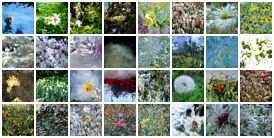

Train :: Epoch: 261/800: 100%|█| 135/135 [00:07<00:00, 17.53it/s, Epoch Loss: 0.
Train :: Epoch: 262/800: 100%|█| 135/135 [00:07<00:00, 18.17it/s, Epoch Loss: 0.
Train :: Epoch: 263/800: 100%|█| 135/135 [00:06<00:00, 19.45it/s, Epoch Loss: 0.
Train :: Epoch: 264/800: 100%|█| 135/135 [00:06<00:00, 19.38it/s, Epoch Loss: 0.
Train :: Epoch: 265/800: 100%|█| 135/135 [00:07<00:00, 19.02it/s, Epoch Loss: 0.
Train :: Epoch: 266/800: 100%|█| 135/135 [00:07<00:00, 17.61it/s, Epoch Loss: 0.
Train :: Epoch: 267/800: 100%|█| 135/135 [00:07<00:00, 17.46it/s, Epoch Loss: 0.
Train :: Epoch: 268/800: 100%|█| 135/135 [00:07<00:00, 17.60it/s, Epoch Loss: 0.
Train :: Epoch: 269/800: 100%|█| 135/135 [00:07<00:00, 18.66it/s, Epoch Loss: 0.
Train :: Epoch: 270/800: 100%|█| 135/135 [00:06<00:00, 19.41it/s, Epoch Loss: 0.
Train :: Epoch: 271/800: 100%|█| 135/135 [00:07<00:00, 18.07it/s, Epoch Loss: 0.
Train :: Epoch: 272/800: 100%|█| 135/135 [00:07<00:00, 17.59it/s, Epoch Loss: 0.
Train :: Epoch: 273/800: 100

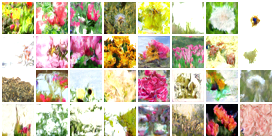

Train :: Epoch: 281/800: 100%|█| 135/135 [00:07<00:00, 17.35it/s, Epoch Loss: 0.
Train :: Epoch: 282/800: 100%|█| 135/135 [00:07<00:00, 17.71it/s, Epoch Loss: 0.
Train :: Epoch: 283/800: 100%|█| 135/135 [00:07<00:00, 17.76it/s, Epoch Loss: 0.
Train :: Epoch: 284/800: 100%|█| 135/135 [00:07<00:00, 17.71it/s, Epoch Loss: 0.
Train :: Epoch: 285/800: 100%|█| 135/135 [00:07<00:00, 17.79it/s, Epoch Loss: 0.
Train :: Epoch: 286/800: 100%|█| 135/135 [00:07<00:00, 17.65it/s, Epoch Loss: 0.
Train :: Epoch: 287/800: 100%|█| 135/135 [00:07<00:00, 17.68it/s, Epoch Loss: 0.
Train :: Epoch: 288/800: 100%|█| 135/135 [00:07<00:00, 17.76it/s, Epoch Loss: 0.
Train :: Epoch: 289/800: 100%|█| 135/135 [00:07<00:00, 19.08it/s, Epoch Loss: 0.
Train :: Epoch: 290/800: 100%|█| 135/135 [00:07<00:00, 18.84it/s, Epoch Loss: 0.
Train :: Epoch: 291/800: 100%|█| 135/135 [00:07<00:00, 17.88it/s, Epoch Loss: 0.
Train :: Epoch: 292/800: 100%|█| 135/135 [00:07<00:00, 18.40it/s, Epoch Loss: 0.
Train :: Epoch: 293/800: 100

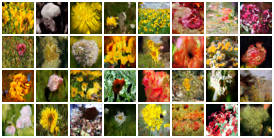

Train :: Epoch: 301/800: 100%|█| 135/135 [00:07<00:00, 17.69it/s, Epoch Loss: 0.
Train :: Epoch: 302/800: 100%|█| 135/135 [00:07<00:00, 17.75it/s, Epoch Loss: 0.
Train :: Epoch: 303/800: 100%|█| 135/135 [00:07<00:00, 19.14it/s, Epoch Loss: 0.
Train :: Epoch: 304/800: 100%|█| 135/135 [00:07<00:00, 19.03it/s, Epoch Loss: 0.
Train :: Epoch: 305/800: 100%|█| 135/135 [00:07<00:00, 18.44it/s, Epoch Loss: 0.
Train :: Epoch: 306/800: 100%|█| 135/135 [00:07<00:00, 17.45it/s, Epoch Loss: 0.
Train :: Epoch: 307/800: 100%|█| 135/135 [00:07<00:00, 17.35it/s, Epoch Loss: 0.
Train :: Epoch: 308/800: 100%|█| 135/135 [00:07<00:00, 18.68it/s, Epoch Loss: 0.
Train :: Epoch: 309/800: 100%|█| 135/135 [00:07<00:00, 19.24it/s, Epoch Loss: 0.
Train :: Epoch: 310/800: 100%|█| 135/135 [00:07<00:00, 19.08it/s, Epoch Loss: 0.
Train :: Epoch: 311/800: 100%|█| 135/135 [00:07<00:00, 17.76it/s, Epoch Loss: 0.
Train :: Epoch: 312/800: 100%|█| 135/135 [00:07<00:00, 17.55it/s, Epoch Loss: 0.
Train :: Epoch: 313/800: 100

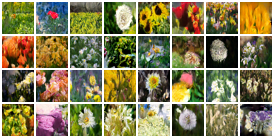

Train :: Epoch: 321/800: 100%|█| 135/135 [00:07<00:00, 19.18it/s, Epoch Loss: 0.
Train :: Epoch: 322/800: 100%|█| 135/135 [00:07<00:00, 18.76it/s, Epoch Loss: 0.
Train :: Epoch: 323/800: 100%|█| 135/135 [00:07<00:00, 18.64it/s, Epoch Loss: 0.
Train :: Epoch: 324/800: 100%|█| 135/135 [00:07<00:00, 17.38it/s, Epoch Loss: 0.
Train :: Epoch: 325/800: 100%|█| 135/135 [00:07<00:00, 17.23it/s, Epoch Loss: 0.
Train :: Epoch: 326/800: 100%|█| 135/135 [00:07<00:00, 19.08it/s, Epoch Loss: 0.
Train :: Epoch: 327/800: 100%|█| 135/135 [00:07<00:00, 19.17it/s, Epoch Loss: 0.
Train :: Epoch: 328/800: 100%|█| 135/135 [00:07<00:00, 18.90it/s, Epoch Loss: 0.
Train :: Epoch: 329/800: 100%|█| 135/135 [00:07<00:00, 17.68it/s, Epoch Loss: 0.
Train :: Epoch: 330/800: 100%|█| 135/135 [00:07<00:00, 17.25it/s, Epoch Loss: 0.
Train :: Epoch: 331/800: 100%|█| 135/135 [00:07<00:00, 17.32it/s, Epoch Loss: 0.
Train :: Epoch: 332/800: 100%|█| 135/135 [00:07<00:00, 18.97it/s, Epoch Loss: 0.
Train :: Epoch: 333/800: 100

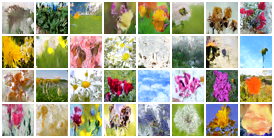

Train :: Epoch: 341/800: 100%|█| 135/135 [00:07<00:00, 18.28it/s, Epoch Loss: 0.
Train :: Epoch: 342/800: 100%|█| 135/135 [00:07<00:00, 18.65it/s, Epoch Loss: 0.
Train :: Epoch: 343/800: 100%|█| 135/135 [00:07<00:00, 18.40it/s, Epoch Loss: 0.
Train :: Epoch: 344/800: 100%|█| 135/135 [00:07<00:00, 18.19it/s, Epoch Loss: 0.
Train :: Epoch: 345/800: 100%|█| 135/135 [00:07<00:00, 18.21it/s, Epoch Loss: 0.
Train :: Epoch: 346/800: 100%|█| 135/135 [00:07<00:00, 18.22it/s, Epoch Loss: 0.
Train :: Epoch: 347/800: 100%|█| 135/135 [00:07<00:00, 18.38it/s, Epoch Loss: 0.
Train :: Epoch: 348/800: 100%|█| 135/135 [00:07<00:00, 18.28it/s, Epoch Loss: 0.
Train :: Epoch: 349/800: 100%|█| 135/135 [00:07<00:00, 18.35it/s, Epoch Loss: 0.
Train :: Epoch: 350/800: 100%|█| 135/135 [00:07<00:00, 18.46it/s, Epoch Loss: 0.
Train :: Epoch: 351/800: 100%|█| 135/135 [00:07<00:00, 18.07it/s, Epoch Loss: 0.
Train :: Epoch: 352/800: 100%|█| 135/135 [00:07<00:00, 17.95it/s, Epoch Loss: 0.
Train :: Epoch: 353/800: 100

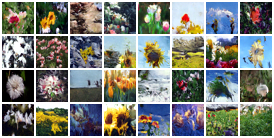

Train :: Epoch: 361/800: 100%|█| 135/135 [00:07<00:00, 17.75it/s, Epoch Loss: 0.
Train :: Epoch: 362/800: 100%|█| 135/135 [00:07<00:00, 19.17it/s, Epoch Loss: 0.
Train :: Epoch: 363/800: 100%|█| 135/135 [00:07<00:00, 19.22it/s, Epoch Loss: 0.
Train :: Epoch: 364/800: 100%|█| 135/135 [00:07<00:00, 18.55it/s, Epoch Loss: 0.
Train :: Epoch: 365/800: 100%|█| 135/135 [00:07<00:00, 17.73it/s, Epoch Loss: 0.
Train :: Epoch: 366/800: 100%|█| 135/135 [00:07<00:00, 17.59it/s, Epoch Loss: 0.
Train :: Epoch: 367/800: 100%|█| 135/135 [00:07<00:00, 17.59it/s, Epoch Loss: 0.
Train :: Epoch: 368/800: 100%|█| 135/135 [00:06<00:00, 19.51it/s, Epoch Loss: 0.
Train :: Epoch: 369/800: 100%|█| 135/135 [00:07<00:00, 19.06it/s, Epoch Loss: 0.
Train :: Epoch: 370/800: 100%|█| 135/135 [00:07<00:00, 18.46it/s, Epoch Loss: 0.
Train :: Epoch: 371/800: 100%|█| 135/135 [00:07<00:00, 17.36it/s, Epoch Loss: 0.
Train :: Epoch: 372/800: 100%|█| 135/135 [00:08<00:00, 16.75it/s, Epoch Loss: 0.
Train :: Epoch: 373/800: 100

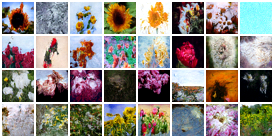

Train :: Epoch: 381/800: 100%|█| 135/135 [00:07<00:00, 18.77it/s, Epoch Loss: 0.
Train :: Epoch: 382/800: 100%|█| 135/135 [00:07<00:00, 18.70it/s, Epoch Loss: 0.
Train :: Epoch: 383/800: 100%|█| 135/135 [00:07<00:00, 18.44it/s, Epoch Loss: 0.
Train :: Epoch: 384/800: 100%|█| 135/135 [00:07<00:00, 17.78it/s, Epoch Loss: 0.
Train :: Epoch: 385/800: 100%|█| 135/135 [00:07<00:00, 17.93it/s, Epoch Loss: 0.
Train :: Epoch: 386/800: 100%|█| 135/135 [00:07<00:00, 17.94it/s, Epoch Loss: 0.
Train :: Epoch: 387/800: 100%|█| 135/135 [00:07<00:00, 17.96it/s, Epoch Loss: 0.
Train :: Epoch: 388/800: 100%|█| 135/135 [00:07<00:00, 18.08it/s, Epoch Loss: 0.
Train :: Epoch: 389/800: 100%|█| 135/135 [00:07<00:00, 17.81it/s, Epoch Loss: 0.
Train :: Epoch: 390/800: 100%|█| 135/135 [00:07<00:00, 18.08it/s, Epoch Loss: 0.
Train :: Epoch: 391/800: 100%|█| 135/135 [00:07<00:00, 17.90it/s, Epoch Loss: 0.
Train :: Epoch: 392/800: 100%|█| 135/135 [00:07<00:00, 17.90it/s, Epoch Loss: 0.
Train :: Epoch: 393/800: 100

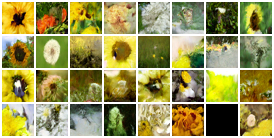

Train :: Epoch: 401/800: 100%|█| 135/135 [00:07<00:00, 18.60it/s, Epoch Loss: 0.
Train :: Epoch: 402/800: 100%|█| 135/135 [00:07<00:00, 18.38it/s, Epoch Loss: 0.
Train :: Epoch: 403/800: 100%|█| 135/135 [00:07<00:00, 18.18it/s, Epoch Loss: 0.
Train :: Epoch: 404/800: 100%|█| 135/135 [00:07<00:00, 17.97it/s, Epoch Loss: 0.
Train :: Epoch: 405/800: 100%|█| 135/135 [00:07<00:00, 17.93it/s, Epoch Loss: 0.
Train :: Epoch: 406/800: 100%|█| 135/135 [00:07<00:00, 17.94it/s, Epoch Loss: 0.
Train :: Epoch: 407/800: 100%|█| 135/135 [00:07<00:00, 17.88it/s, Epoch Loss: 0.
Train :: Epoch: 408/800: 100%|█| 135/135 [00:07<00:00, 18.26it/s, Epoch Loss: 0.
Train :: Epoch: 409/800: 100%|█| 135/135 [00:07<00:00, 17.99it/s, Epoch Loss: 0.
Train :: Epoch: 410/800: 100%|█| 135/135 [00:07<00:00, 17.97it/s, Epoch Loss: 0.
Train :: Epoch: 411/800: 100%|█| 135/135 [00:07<00:00, 18.57it/s, Epoch Loss: 0.
Train :: Epoch: 412/800: 100%|█| 135/135 [00:07<00:00, 18.43it/s, Epoch Loss: 0.
Train :: Epoch: 413/800: 100

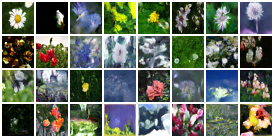

Train :: Epoch: 421/800: 100%|█| 135/135 [00:07<00:00, 18.34it/s, Epoch Loss: 0.
Train :: Epoch: 422/800: 100%|█| 135/135 [00:07<00:00, 19.07it/s, Epoch Loss: 0.
Train :: Epoch: 423/800: 100%|█| 135/135 [00:07<00:00, 18.20it/s, Epoch Loss: 0.
Train :: Epoch: 424/800: 100%|█| 135/135 [00:07<00:00, 18.52it/s, Epoch Loss: 0.
Train :: Epoch: 425/800: 100%|█| 135/135 [00:07<00:00, 18.46it/s, Epoch Loss: 0.
Train :: Epoch: 426/800: 100%|█| 135/135 [00:07<00:00, 18.37it/s, Epoch Loss: 0.
Train :: Epoch: 427/800: 100%|█| 135/135 [00:07<00:00, 19.09it/s, Epoch Loss: 0.
Train :: Epoch: 428/800: 100%|█| 135/135 [00:07<00:00, 18.28it/s, Epoch Loss: 0.
Train :: Epoch: 429/800: 100%|█| 135/135 [00:07<00:00, 18.67it/s, Epoch Loss: 0.
Train :: Epoch: 430/800: 100%|█| 135/135 [00:07<00:00, 17.84it/s, Epoch Loss: 0.
Train :: Epoch: 431/800: 100%|█| 135/135 [00:07<00:00, 17.47it/s, Epoch Loss: 0.
Train :: Epoch: 432/800: 100%|█| 135/135 [00:07<00:00, 17.73it/s, Epoch Loss: 0.
Train :: Epoch: 433/800: 100

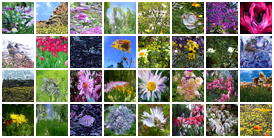

Train :: Epoch: 441/800: 100%|█| 135/135 [00:07<00:00, 18.80it/s, Epoch Loss: 0.
Train :: Epoch: 442/800: 100%|█| 135/135 [00:06<00:00, 19.32it/s, Epoch Loss: 0.
Train :: Epoch: 443/800: 100%|█| 135/135 [00:07<00:00, 18.93it/s, Epoch Loss: 0.
Train :: Epoch: 444/800: 100%|█| 135/135 [00:07<00:00, 18.22it/s, Epoch Loss: 0.
Train :: Epoch: 445/800: 100%|█| 135/135 [00:07<00:00, 17.98it/s, Epoch Loss: 0.
Train :: Epoch: 446/800: 100%|█| 135/135 [00:07<00:00, 17.85it/s, Epoch Loss: 0.
Train :: Epoch: 447/800: 100%|█| 135/135 [00:07<00:00, 17.79it/s, Epoch Loss: 0.
Train :: Epoch: 448/800: 100%|█| 135/135 [00:07<00:00, 17.92it/s, Epoch Loss: 0.
Train :: Epoch: 449/800: 100%|█| 135/135 [00:07<00:00, 17.79it/s, Epoch Loss: 0.
Train :: Epoch: 450/800: 100%|█| 135/135 [00:07<00:00, 17.82it/s, Epoch Loss: 0.
Train :: Epoch: 451/800: 100%|█| 135/135 [00:07<00:00, 17.93it/s, Epoch Loss: 0.
Train :: Epoch: 452/800: 100%|█| 135/135 [00:07<00:00, 17.83it/s, Epoch Loss: 0.
Train :: Epoch: 453/800: 100

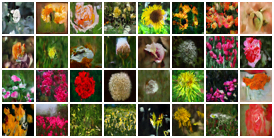

Train :: Epoch: 461/800: 100%|█| 135/135 [00:07<00:00, 17.57it/s, Epoch Loss: 0.
Train :: Epoch: 462/800: 100%|█| 135/135 [00:07<00:00, 17.99it/s, Epoch Loss: 0.
Train :: Epoch: 463/800: 100%|█| 135/135 [00:07<00:00, 18.00it/s, Epoch Loss: 0.
Train :: Epoch: 464/800: 100%|█| 135/135 [00:07<00:00, 17.91it/s, Epoch Loss: 0.
Train :: Epoch: 465/800: 100%|█| 135/135 [00:07<00:00, 18.02it/s, Epoch Loss: 0.
Train :: Epoch: 466/800: 100%|█| 135/135 [00:07<00:00, 18.65it/s, Epoch Loss: 0.
Train :: Epoch: 467/800: 100%|█| 135/135 [00:07<00:00, 18.95it/s, Epoch Loss: 0.
Train :: Epoch: 468/800: 100%|█| 135/135 [00:07<00:00, 18.61it/s, Epoch Loss: 0.
Train :: Epoch: 469/800: 100%|█| 135/135 [00:07<00:00, 17.87it/s, Epoch Loss: 0.
Train :: Epoch: 470/800: 100%|█| 135/135 [00:07<00:00, 17.15it/s, Epoch Loss: 0.
Train :: Epoch: 471/800: 100%|█| 135/135 [00:07<00:00, 19.03it/s, Epoch Loss: 0.
Train :: Epoch: 472/800: 100%|█| 135/135 [00:07<00:00, 18.70it/s, Epoch Loss: 0.
Train :: Epoch: 473/800: 100

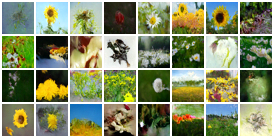

Train :: Epoch: 481/800: 100%|█| 135/135 [00:07<00:00, 18.35it/s, Epoch Loss: 0.
Train :: Epoch: 482/800: 100%|█| 135/135 [00:07<00:00, 19.14it/s, Epoch Loss: 0.
Train :: Epoch: 483/800: 100%|█| 135/135 [00:06<00:00, 19.29it/s, Epoch Loss: 0.
Train :: Epoch: 484/800: 100%|█| 135/135 [00:07<00:00, 17.83it/s, Epoch Loss: 0.
Train :: Epoch: 485/800: 100%|█| 135/135 [00:07<00:00, 17.33it/s, Epoch Loss: 0.
Train :: Epoch: 486/800: 100%|█| 135/135 [00:06<00:00, 19.50it/s, Epoch Loss: 0.
Train :: Epoch: 487/800: 100%|█| 135/135 [00:07<00:00, 19.26it/s, Epoch Loss: 0.
Train :: Epoch: 488/800: 100%|█| 135/135 [00:07<00:00, 18.84it/s, Epoch Loss: 0.
Train :: Epoch: 489/800: 100%|█| 135/135 [00:07<00:00, 18.13it/s, Epoch Loss: 0.
Train :: Epoch: 490/800: 100%|█| 135/135 [00:07<00:00, 17.56it/s, Epoch Loss: 0.
Train :: Epoch: 491/800: 100%|█| 135/135 [00:07<00:00, 17.81it/s, Epoch Loss: 0.
Train :: Epoch: 492/800: 100%|█| 135/135 [00:07<00:00, 17.50it/s, Epoch Loss: 0.
Train :: Epoch: 493/800: 100

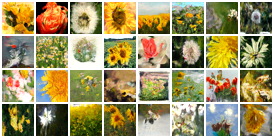

Train :: Epoch: 501/800: 100%|█| 135/135 [00:07<00:00, 17.21it/s, Epoch Loss: 0.
Train :: Epoch: 502/800: 100%|█| 135/135 [00:07<00:00, 17.68it/s, Epoch Loss: 0.
Train :: Epoch: 503/800: 100%|█| 135/135 [00:07<00:00, 18.39it/s, Epoch Loss: 0.
Train :: Epoch: 504/800: 100%|█| 135/135 [00:07<00:00, 19.14it/s, Epoch Loss: 0.
Train :: Epoch: 505/800: 100%|█| 135/135 [00:07<00:00, 19.15it/s, Epoch Loss: 0.
Train :: Epoch: 506/800: 100%|█| 135/135 [00:07<00:00, 17.76it/s, Epoch Loss: 0.
Train :: Epoch: 507/800: 100%|█| 135/135 [00:07<00:00, 17.11it/s, Epoch Loss: 0.
Train :: Epoch: 508/800: 100%|█| 135/135 [00:07<00:00, 17.47it/s, Epoch Loss: 0.
Train :: Epoch: 509/800: 100%|█| 135/135 [00:07<00:00, 17.30it/s, Epoch Loss: 0.
Train :: Epoch: 510/800: 100%|█| 135/135 [00:07<00:00, 18.31it/s, Epoch Loss: 0.
Train :: Epoch: 511/800: 100%|█| 135/135 [00:07<00:00, 19.05it/s, Epoch Loss: 0.
Train :: Epoch: 512/800: 100%|█| 135/135 [00:07<00:00, 18.97it/s, Epoch Loss: 0.
Train :: Epoch: 513/800: 100

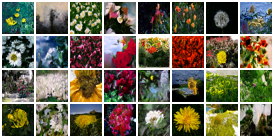

Train :: Epoch: 521/800: 100%|█| 135/135 [00:07<00:00, 17.48it/s, Epoch Loss: 0.
Train :: Epoch: 522/800: 100%|█| 135/135 [00:07<00:00, 17.68it/s, Epoch Loss: 0.
Train :: Epoch: 523/800: 100%|█| 135/135 [00:07<00:00, 18.87it/s, Epoch Loss: 0.
Train :: Epoch: 524/800: 100%|█| 135/135 [00:07<00:00, 18.86it/s, Epoch Loss: 0.
Train :: Epoch: 525/800: 100%|█| 135/135 [00:07<00:00, 18.33it/s, Epoch Loss: 0.
Train :: Epoch: 526/800: 100%|█| 135/135 [00:07<00:00, 17.57it/s, Epoch Loss: 0.
Train :: Epoch: 527/800: 100%|█| 135/135 [00:07<00:00, 17.15it/s, Epoch Loss: 0.
Train :: Epoch: 528/800: 100%|█| 135/135 [00:07<00:00, 17.81it/s, Epoch Loss: 0.
Train :: Epoch: 529/800: 100%|█| 135/135 [00:07<00:00, 17.95it/s, Epoch Loss: 0.
Train :: Epoch: 530/800: 100%|█| 135/135 [00:07<00:00, 19.06it/s, Epoch Loss: 0.
Train :: Epoch: 531/800: 100%|█| 135/135 [00:07<00:00, 18.38it/s, Epoch Loss: 0.
Train :: Epoch: 532/800: 100%|█| 135/135 [00:07<00:00, 17.03it/s, Epoch Loss: 0.
Train :: Epoch: 533/800: 100

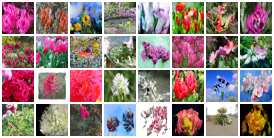

Train :: Epoch: 541/800: 100%|█| 135/135 [00:07<00:00, 17.62it/s, Epoch Loss: 0.
Train :: Epoch: 542/800: 100%|█| 135/135 [00:07<00:00, 18.29it/s, Epoch Loss: 0.
Train :: Epoch: 543/800: 100%|█| 135/135 [00:07<00:00, 18.03it/s, Epoch Loss: 0.
Train :: Epoch: 544/800: 100%|█| 135/135 [00:07<00:00, 17.92it/s, Epoch Loss: 0.
Train :: Epoch: 545/800: 100%|█| 135/135 [00:07<00:00, 17.57it/s, Epoch Loss: 0.
Train :: Epoch: 546/800: 100%|█| 135/135 [00:08<00:00, 16.83it/s, Epoch Loss: 0.
Train :: Epoch: 547/800: 100%|█| 135/135 [00:07<00:00, 17.53it/s, Epoch Loss: 0.
Train :: Epoch: 548/800: 100%|█| 135/135 [00:07<00:00, 18.99it/s, Epoch Loss: 0.
Train :: Epoch: 549/800: 100%|█| 135/135 [00:07<00:00, 18.95it/s, Epoch Loss: 0.
Train :: Epoch: 550/800: 100%|█| 135/135 [00:07<00:00, 18.45it/s, Epoch Loss: 0.
Train :: Epoch: 551/800: 100%|█| 135/135 [00:07<00:00, 17.69it/s, Epoch Loss: 0.
Train :: Epoch: 552/800: 100%|█| 135/135 [00:07<00:00, 17.65it/s, Epoch Loss: 0.
Train :: Epoch: 553/800: 100

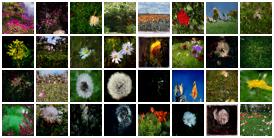

Train :: Epoch: 561/800: 100%|█| 135/135 [00:07<00:00, 18.10it/s, Epoch Loss: 0.
Train :: Epoch: 562/800: 100%|█| 135/135 [00:07<00:00, 18.02it/s, Epoch Loss: 0.
Train :: Epoch: 563/800: 100%|█| 135/135 [00:07<00:00, 18.34it/s, Epoch Loss: 0.
Train :: Epoch: 564/800: 100%|█| 135/135 [00:07<00:00, 18.53it/s, Epoch Loss: 0.
Train :: Epoch: 565/800: 100%|█| 135/135 [00:07<00:00, 18.00it/s, Epoch Loss: 0.
Train :: Epoch: 566/800: 100%|█| 135/135 [00:07<00:00, 18.20it/s, Epoch Loss: 0.
Train :: Epoch: 567/800: 100%|█| 135/135 [00:07<00:00, 18.24it/s, Epoch Loss: 0.
Train :: Epoch: 568/800: 100%|█| 135/135 [00:07<00:00, 18.24it/s, Epoch Loss: 0.
Train :: Epoch: 569/800: 100%|█| 135/135 [00:07<00:00, 18.19it/s, Epoch Loss: 0.
Train :: Epoch: 570/800: 100%|█| 135/135 [00:06<00:00, 19.36it/s, Epoch Loss: 0.
Train :: Epoch: 571/800: 100%|█| 135/135 [00:07<00:00, 18.91it/s, Epoch Loss: 0.
Train :: Epoch: 572/800: 100%|█| 135/135 [00:07<00:00, 18.42it/s, Epoch Loss: 0.
Train :: Epoch: 573/800: 100

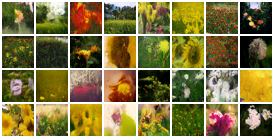

Train :: Epoch: 581/800: 100%|█| 135/135 [00:06<00:00, 19.42it/s, Epoch Loss: 0.
Train :: Epoch: 582/800: 100%|█| 135/135 [00:06<00:00, 19.31it/s, Epoch Loss: 0.
Train :: Epoch: 583/800: 100%|█| 135/135 [00:07<00:00, 19.05it/s, Epoch Loss: 0.
Train :: Epoch: 584/800: 100%|█| 135/135 [00:07<00:00, 17.68it/s, Epoch Loss: 0.
Train :: Epoch: 585/800: 100%|█| 135/135 [00:07<00:00, 17.64it/s, Epoch Loss: 0.
Train :: Epoch: 586/800: 100%|█| 135/135 [00:07<00:00, 16.98it/s, Epoch Loss: 0.
Train :: Epoch: 587/800: 100%|█| 135/135 [00:07<00:00, 19.02it/s, Epoch Loss: 0.
Train :: Epoch: 588/800: 100%|█| 135/135 [00:07<00:00, 19.25it/s, Epoch Loss: 0.
Train :: Epoch: 589/800: 100%|█| 135/135 [00:07<00:00, 18.46it/s, Epoch Loss: 0.
Train :: Epoch: 590/800: 100%|█| 135/135 [00:07<00:00, 17.03it/s, Epoch Loss: 0.
Train :: Epoch: 591/800: 100%|█| 135/135 [00:08<00:00, 16.86it/s, Epoch Loss: 0.
Train :: Epoch: 592/800: 100%|█| 135/135 [00:07<00:00, 17.23it/s, Epoch Loss: 0.
Train :: Epoch: 593/800: 100

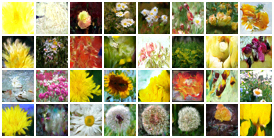

Train :: Epoch: 601/800: 100%|█| 135/135 [00:07<00:00, 18.90it/s, Epoch Loss: 0.
Train :: Epoch: 602/800: 100%|█| 135/135 [00:07<00:00, 18.87it/s, Epoch Loss: 0.
Train :: Epoch: 603/800: 100%|█| 135/135 [00:07<00:00, 18.69it/s, Epoch Loss: 0.
Train :: Epoch: 604/800: 100%|█| 135/135 [00:07<00:00, 17.36it/s, Epoch Loss: 0.
Train :: Epoch: 605/800: 100%|█| 135/135 [00:07<00:00, 17.77it/s, Epoch Loss: 0.
Train :: Epoch: 606/800: 100%|█| 135/135 [00:07<00:00, 18.92it/s, Epoch Loss: 0.
Train :: Epoch: 607/800: 100%|█| 135/135 [00:07<00:00, 18.45it/s, Epoch Loss: 0.
Train :: Epoch: 608/800: 100%|█| 135/135 [00:07<00:00, 18.03it/s, Epoch Loss: 0.
Train :: Epoch: 609/800: 100%|█| 135/135 [00:07<00:00, 16.90it/s, Epoch Loss: 0.
Train :: Epoch: 610/800: 100%|█| 135/135 [00:08<00:00, 16.10it/s, Epoch Loss: 0.
Train :: Epoch: 611/800: 100%|█| 135/135 [00:07<00:00, 17.34it/s, Epoch Loss: 0.
Train :: Epoch: 612/800: 100%|█| 135/135 [00:07<00:00, 18.00it/s, Epoch Loss: 0.
Train :: Epoch: 613/800: 100

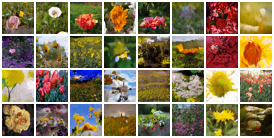

Train :: Epoch: 621/800: 100%|█| 135/135 [00:07<00:00, 17.28it/s, Epoch Loss: 0.
Train :: Epoch: 622/800: 100%|█| 135/135 [00:07<00:00, 19.05it/s, Epoch Loss: 0.
Train :: Epoch: 623/800: 100%|█| 135/135 [00:07<00:00, 19.20it/s, Epoch Loss: 0.
Train :: Epoch: 624/800: 100%|█| 135/135 [00:07<00:00, 19.04it/s, Epoch Loss: 0.
Train :: Epoch: 625/800: 100%|█| 135/135 [00:07<00:00, 17.30it/s, Epoch Loss: 0.
Train :: Epoch: 626/800: 100%|█| 135/135 [00:07<00:00, 18.19it/s, Epoch Loss: 0.
Train :: Epoch: 627/800: 100%|█| 135/135 [00:07<00:00, 19.03it/s, Epoch Loss: 0.
Train :: Epoch: 628/800: 100%|█| 135/135 [00:07<00:00, 18.68it/s, Epoch Loss: 0.
Train :: Epoch: 629/800: 100%|█| 135/135 [00:07<00:00, 17.85it/s, Epoch Loss: 0.
Train :: Epoch: 630/800: 100%|█| 135/135 [00:07<00:00, 17.56it/s, Epoch Loss: 0.
Train :: Epoch: 631/800: 100%|█| 135/135 [00:07<00:00, 17.75it/s, Epoch Loss: 0.
Train :: Epoch: 632/800: 100%|█| 135/135 [00:07<00:00, 17.55it/s, Epoch Loss: 0.
Train :: Epoch: 633/800: 100

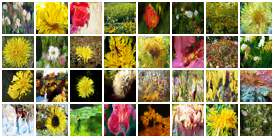

Train :: Epoch: 641/800: 100%|█| 135/135 [00:08<00:00, 16.86it/s, Epoch Loss: 0.
Train :: Epoch: 642/800: 100%|█| 135/135 [00:07<00:00, 17.34it/s, Epoch Loss: 0.
Train :: Epoch: 643/800: 100%|█| 135/135 [00:07<00:00, 18.50it/s, Epoch Loss: 0.
Train :: Epoch: 644/800: 100%|█| 135/135 [00:06<00:00, 19.31it/s, Epoch Loss: 0.
Train :: Epoch: 645/800: 100%|█| 135/135 [00:07<00:00, 18.79it/s, Epoch Loss: 0.
Train :: Epoch: 646/800: 100%|█| 135/135 [00:07<00:00, 18.11it/s, Epoch Loss: 0.
Train :: Epoch: 647/800: 100%|█| 135/135 [00:07<00:00, 17.31it/s, Epoch Loss: 0.
Train :: Epoch: 648/800: 100%|█| 135/135 [00:07<00:00, 17.15it/s, Epoch Loss: 0.
Train :: Epoch: 649/800: 100%|█| 135/135 [00:07<00:00, 18.94it/s, Epoch Loss: 0.
Train :: Epoch: 650/800: 100%|█| 135/135 [00:07<00:00, 18.04it/s, Epoch Loss: 0.
Train :: Epoch: 651/800: 100%|█| 135/135 [00:07<00:00, 18.55it/s, Epoch Loss: 0.
Train :: Epoch: 652/800: 100%|█| 135/135 [00:07<00:00, 17.62it/s, Epoch Loss: 0.
Train :: Epoch: 653/800: 100

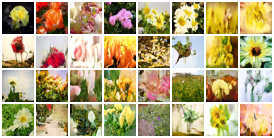

Train :: Epoch: 661/800: 100%|█| 135/135 [00:07<00:00, 17.20it/s, Epoch Loss: 0.
Train :: Epoch: 662/800: 100%|█| 135/135 [00:07<00:00, 19.00it/s, Epoch Loss: 0.
Train :: Epoch: 663/800: 100%|█| 135/135 [00:07<00:00, 18.86it/s, Epoch Loss: 0.
Train :: Epoch: 664/800: 100%|█| 135/135 [00:07<00:00, 18.70it/s, Epoch Loss: 0.
Train :: Epoch: 665/800: 100%|█| 135/135 [00:07<00:00, 17.60it/s, Epoch Loss: 0.
Train :: Epoch: 666/800: 100%|█| 135/135 [00:07<00:00, 17.44it/s, Epoch Loss: 0.
Train :: Epoch: 667/800: 100%|█| 135/135 [00:07<00:00, 17.28it/s, Epoch Loss: 0.
Train :: Epoch: 668/800: 100%|█| 135/135 [00:07<00:00, 18.82it/s, Epoch Loss: 0.
Train :: Epoch: 669/800: 100%|█| 135/135 [00:07<00:00, 19.16it/s, Epoch Loss: 0.
Train :: Epoch: 670/800: 100%|█| 135/135 [00:07<00:00, 18.83it/s, Epoch Loss: 0.
Train :: Epoch: 671/800: 100%|█| 135/135 [00:07<00:00, 17.66it/s, Epoch Loss: 0.
Train :: Epoch: 672/800: 100%|█| 135/135 [00:08<00:00, 16.36it/s, Epoch Loss: 0.
Train :: Epoch: 673/800: 100

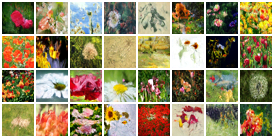

Train :: Epoch: 681/800: 100%|█| 135/135 [00:07<00:00, 18.84it/s, Epoch Loss: 0.
Train :: Epoch: 682/800: 100%|█| 135/135 [00:07<00:00, 19.03it/s, Epoch Loss: 0.
Train :: Epoch: 683/800: 100%|█| 135/135 [00:07<00:00, 18.23it/s, Epoch Loss: 0.
Train :: Epoch: 684/800: 100%|█| 135/135 [00:07<00:00, 16.98it/s, Epoch Loss: 0.
Train :: Epoch: 685/800: 100%|█| 135/135 [00:07<00:00, 17.89it/s, Epoch Loss: 0.
Train :: Epoch: 686/800: 100%|█| 135/135 [00:06<00:00, 19.39it/s, Epoch Loss: 0.
Train :: Epoch: 687/800: 100%|█| 135/135 [00:06<00:00, 19.31it/s, Epoch Loss: 0.
Train :: Epoch: 688/800: 100%|█| 135/135 [00:07<00:00, 18.36it/s, Epoch Loss: 0.
Train :: Epoch: 689/800: 100%|█| 135/135 [00:07<00:00, 17.47it/s, Epoch Loss: 0.
Train :: Epoch: 690/800: 100%|█| 135/135 [00:07<00:00, 18.01it/s, Epoch Loss: 0.
Train :: Epoch: 691/800: 100%|█| 135/135 [00:07<00:00, 18.68it/s, Epoch Loss: 0.
Train :: Epoch: 692/800: 100%|█| 135/135 [00:07<00:00, 18.28it/s, Epoch Loss: 0.
Train :: Epoch: 693/800: 100

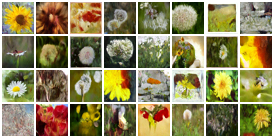

Train :: Epoch: 701/800: 100%|█| 135/135 [00:07<00:00, 17.12it/s, Epoch Loss: 0.
Train :: Epoch: 702/800: 100%|█| 135/135 [00:07<00:00, 18.92it/s, Epoch Loss: 0.
Train :: Epoch: 703/800: 100%|█| 135/135 [00:07<00:00, 18.91it/s, Epoch Loss: 0.
Train :: Epoch: 704/800: 100%|█| 135/135 [00:07<00:00, 18.30it/s, Epoch Loss: 0.
Train :: Epoch: 705/800: 100%|█| 135/135 [00:07<00:00, 16.96it/s, Epoch Loss: 0.
Train :: Epoch: 706/800: 100%|█| 135/135 [00:07<00:00, 17.61it/s, Epoch Loss: 0.
Train :: Epoch: 707/800: 100%|█| 135/135 [00:07<00:00, 17.69it/s, Epoch Loss: 0.
Train :: Epoch: 708/800: 100%|█| 135/135 [00:06<00:00, 19.40it/s, Epoch Loss: 0.
Train :: Epoch: 709/800: 100%|█| 135/135 [00:07<00:00, 18.90it/s, Epoch Loss: 0.
Train :: Epoch: 710/800: 100%|█| 135/135 [00:07<00:00, 18.76it/s, Epoch Loss: 0.
Train :: Epoch: 711/800: 100%|█| 135/135 [00:07<00:00, 17.81it/s, Epoch Loss: 0.
Train :: Epoch: 712/800: 100%|█| 135/135 [00:07<00:00, 19.08it/s, Epoch Loss: 0.
Train :: Epoch: 713/800: 100

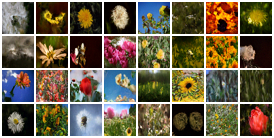

Train :: Epoch: 721/800: 100%|█| 135/135 [00:07<00:00, 17.59it/s, Epoch Loss: 0.
Train :: Epoch: 722/800: 100%|█| 135/135 [00:07<00:00, 18.00it/s, Epoch Loss: 0.
Train :: Epoch: 723/800: 100%|█| 135/135 [00:07<00:00, 17.97it/s, Epoch Loss: 0.
Train :: Epoch: 724/800: 100%|█| 135/135 [00:07<00:00, 17.97it/s, Epoch Loss: 0.
Train :: Epoch: 725/800: 100%|█| 135/135 [00:07<00:00, 18.08it/s, Epoch Loss: 0.
Train :: Epoch: 726/800: 100%|█| 135/135 [00:07<00:00, 18.04it/s, Epoch Loss: 0.
Train :: Epoch: 727/800: 100%|█| 135/135 [00:07<00:00, 17.86it/s, Epoch Loss: 0.
Train :: Epoch: 728/800: 100%|█| 135/135 [00:07<00:00, 17.76it/s, Epoch Loss: 0.
Train :: Epoch: 729/800: 100%|█| 135/135 [00:07<00:00, 17.92it/s, Epoch Loss: 0.
Train :: Epoch: 730/800: 100%|█| 135/135 [00:07<00:00, 17.92it/s, Epoch Loss: 0.
Train :: Epoch: 731/800: 100%|█| 135/135 [00:07<00:00, 17.93it/s, Epoch Loss: 0.
Train :: Epoch: 732/800: 100%|█| 135/135 [00:07<00:00, 17.86it/s, Epoch Loss: 0.
Train :: Epoch: 733/800: 100

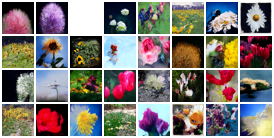

Train :: Epoch: 741/800: 100%|█| 135/135 [00:07<00:00, 18.51it/s, Epoch Loss: 0.
Train :: Epoch: 742/800: 100%|█| 135/135 [00:07<00:00, 18.79it/s, Epoch Loss: 0.
Train :: Epoch: 743/800: 100%|█| 135/135 [00:07<00:00, 18.63it/s, Epoch Loss: 0.
Train :: Epoch: 744/800: 100%|█| 135/135 [00:07<00:00, 17.46it/s, Epoch Loss: 0.
Train :: Epoch: 745/800: 100%|█| 135/135 [00:07<00:00, 17.07it/s, Epoch Loss: 0.
Train :: Epoch: 746/800: 100%|█| 135/135 [00:07<00:00, 17.38it/s, Epoch Loss: 0.
Train :: Epoch: 747/800: 100%|█| 135/135 [00:07<00:00, 17.81it/s, Epoch Loss: 0.
Train :: Epoch: 748/800: 100%|█| 135/135 [00:07<00:00, 18.62it/s, Epoch Loss: 0.
Train :: Epoch: 749/800: 100%|█| 135/135 [00:07<00:00, 18.69it/s, Epoch Loss: 0.
Train :: Epoch: 750/800: 100%|█| 135/135 [00:07<00:00, 17.59it/s, Epoch Loss: 0.
Train :: Epoch: 751/800: 100%|█| 135/135 [00:08<00:00, 16.47it/s, Epoch Loss: 0.
Train :: Epoch: 752/800: 100%|█| 135/135 [00:07<00:00, 18.13it/s, Epoch Loss: 0.
Train :: Epoch: 753/800: 100

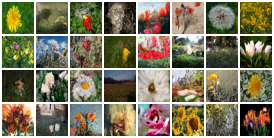

Train :: Epoch: 761/800: 100%|█| 135/135 [00:07<00:00, 17.99it/s, Epoch Loss: 0.
Train :: Epoch: 762/800: 100%|█| 135/135 [00:07<00:00, 19.03it/s, Epoch Loss: 0.
Train :: Epoch: 763/800: 100%|█| 135/135 [00:07<00:00, 18.69it/s, Epoch Loss: 0.
Train :: Epoch: 764/800: 100%|█| 135/135 [00:07<00:00, 18.68it/s, Epoch Loss: 0.
Train :: Epoch: 765/800: 100%|█| 135/135 [00:07<00:00, 18.48it/s, Epoch Loss: 0.
Train :: Epoch: 766/800: 100%|█| 135/135 [00:07<00:00, 18.22it/s, Epoch Loss: 0.
Train :: Epoch: 767/800: 100%|█| 135/135 [00:07<00:00, 18.02it/s, Epoch Loss: 0.
Train :: Epoch: 768/800: 100%|█| 135/135 [00:07<00:00, 18.54it/s, Epoch Loss: 0.
Train :: Epoch: 769/800: 100%|█| 135/135 [00:07<00:00, 18.71it/s, Epoch Loss: 0.
Train :: Epoch: 770/800: 100%|█| 135/135 [00:07<00:00, 18.56it/s, Epoch Loss: 0.
Train :: Epoch: 771/800: 100%|█| 135/135 [00:07<00:00, 17.90it/s, Epoch Loss: 0.
Train :: Epoch: 772/800: 100%|█| 135/135 [00:07<00:00, 19.06it/s, Epoch Loss: 0.
Train :: Epoch: 773/800: 100

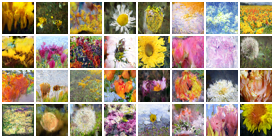

Train :: Epoch: 781/800: 100%|█| 135/135 [00:07<00:00, 17.12it/s, Epoch Loss: 0.
Train :: Epoch: 782/800: 100%|█| 135/135 [00:07<00:00, 17.16it/s, Epoch Loss: 0.
Train :: Epoch: 783/800: 100%|█| 135/135 [00:07<00:00, 17.66it/s, Epoch Loss: 0.
Train :: Epoch: 784/800: 100%|█| 135/135 [00:07<00:00, 19.06it/s, Epoch Loss: 0.
Train :: Epoch: 785/800: 100%|█| 135/135 [00:07<00:00, 18.98it/s, Epoch Loss: 0.
Train :: Epoch: 786/800: 100%|█| 135/135 [00:07<00:00, 18.53it/s, Epoch Loss: 0.
Train :: Epoch: 787/800: 100%|█| 135/135 [00:07<00:00, 17.83it/s, Epoch Loss: 0.
Train :: Epoch: 788/800: 100%|█| 135/135 [00:07<00:00, 18.57it/s, Epoch Loss: 0.
Train :: Epoch: 789/800: 100%|█| 135/135 [00:07<00:00, 18.73it/s, Epoch Loss: 0.
Train :: Epoch: 790/800: 100%|█| 135/135 [00:07<00:00, 18.46it/s, Epoch Loss: 0.
Train :: Epoch: 791/800: 100%|█| 135/135 [00:07<00:00, 16.90it/s, Epoch Loss: 0.
Train :: Epoch: 792/800: 100%|█| 135/135 [00:07<00:00, 19.02it/s, Epoch Loss: 0.
Train :: Epoch: 793/800: 100

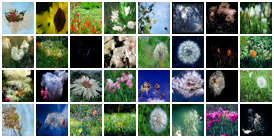

In [40]:
for epoch in range(1, total_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch)

    if epoch % 20 == 0:
        save_path = os.path.join(log_dir, f"{epoch}{ext}")
        
        # Algorithm 2: Sampling
        reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, num_images=32, generate_video=generate_video,
            save_path=save_path, img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE,
        )

        # clear_output()
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.tar"))
        del checkpoint_dict

### Inference

In [41]:
model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ckpt.tar"), map_location='cpu')['model'])

model.to(BaseConfig.DEVICE)

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

Sampling :: 100%|█████████████████████████████| 999/999 [01:28<00:00, 11.27it/s]


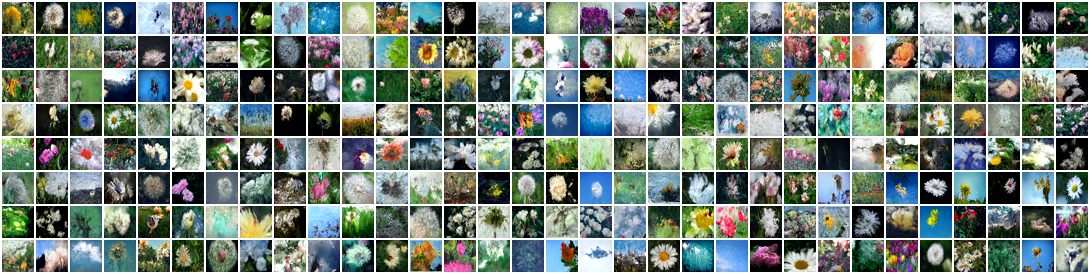

inference_results/20230605-222618.mp4


In [42]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=256,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=32,
)
print(save_path)

Sampling :: 100%|█████████████████████████████| 999/999 [00:45<00:00, 21.88it/s]


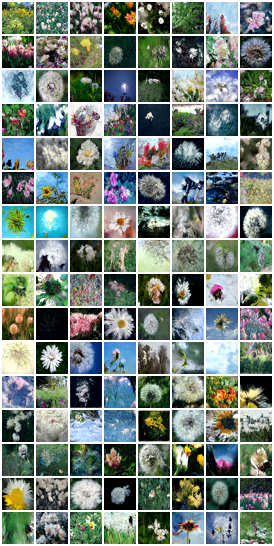

inference_results/20230606-105408.png


In [43]:
generate_video = False

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)


reverse_diffusion(
    model,
    sd,
    num_images=128,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=8,
)

print(save_path)

Sampling :: 100%|█████████████████████████████| 999/999 [00:13<00:00, 72.96it/s]


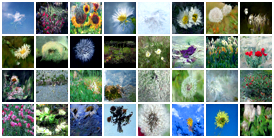

In [44]:
generate_gif = False

ext = ".gif" if generate_gif else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)


reverse_diffusion(
    model,
    sd,
    num_images=32,
    generate_gif=generate_gif,
    save_path=save_path,
    timsteps=TrainingConfig.TIMESTEPS,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
)